In [20]:
# import the libraries
import torch
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import trange, tqdm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr

In [21]:
# Load the data
tensile_df =  pd.read_excel("../Tensile_Properties_Data.xlsx", header=0, skiprows=1)
tensile_df

,Reference,Material,Material Group,C (wt.%),Si (wt.%),Mn (wt.%),P (wt.%),S (wt.%),Ni (wt.%),Cr (wt.%),...,Width (mm),Aspect Ratio (L/W),Aspect Ratio (R/W),Aspect Ratio (T/W),Test Temperature (C),Strain Rate (1/s),Yield Strength (MPa),Ultimate Tensile Strength (MPa),Uniform Elongation (%),Total Elongation (%)
0,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,1.2,4.166700,1.1667,0.625000,23.0,0.001000,274.0,789.0,67.00,76.00
1,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,0.8,4.437500,0.3750,0.500000,23.0,0.001000,272.0,781.0,69.00,80.00
2,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,1.2,4.166700,1.1667,0.416667,23.0,0.001000,710.0,767.0,7.90,14.80
3,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,607.0,760.0,10.80,23.10
4,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,725.0,782.0,6.60,18.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,114.0,0.222807,NaN,0.114035,760.0,0.000067,214.0,572.0,59.35,67.66
1469,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.000067,207.0,494.0,38.80,47.80
1470,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.003667,101.0,352.0,31.22,47.25
1471,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,25.0,2.032000,NaN,0.000000,760.0,0.000067,177.0,497.0,40.40,46.50


In [22]:
# Check the data information for each column.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        1473 non-null   int64  
 1   Material                         1473 non-null   object 
 2   Material Group                   1473 non-null   object 
 3   C (wt.%)                         1210 non-null   object 
 4   Si (wt.%)                        1174 non-null   float64
 5   Mn (wt.%)                        1179 non-null   float64
 6   P (wt.%)                         1157 non-null   float64
 7   S (wt.%)                         965 non-null    float64
 8   Ni (wt.%)                        1387 non-null   float64
 9   Cr (wt.%)                        1404 non-null   float64
 10  Mo (wt.%)                        1331 non-null   float64
 11  Al (wt.%)                        484 non-null    float64
 12  N (wt.%)            

In [23]:
# Select the composition columns
compostion_cols = tensile_df.columns[3:29]
compostion_cols

Index(['C (wt.%)', 'Si (wt.%)', 'Mn (wt.%)', 'P (wt.%)', 'S (wt.%)',
       'Ni (wt.%)', 'Cr (wt.%)', 'Mo (wt.%)', 'Al (wt.%)', 'N (wt.%)',
       'Ti (wt.%)', 'Fe (wt.%)', 'Nb (wt.%)', 'B (wt.%)', 'Cu (wt.%)',
       'V (wt.%)', 'Mg (wt.%)', 'Y (wt.%)', 'Zr (wt.%)', 'Zn (wt.%)',
       'W (wt.%)', 'Sn (wt.%)', 'Co (wt.%)', 'O (wt.,%)', 'Ta (wt.%)',
       'H (wt.%)'],
      dtype='object')

In [24]:
# Fill the nan values with 0 for the comospition columns
tensile_df[compostion_cols]  = tensile_df[compostion_cols].fillna(0)
tensile_df['Irradiation Dose (mdpa)']  = tensile_df['Irradiation Dose (mdpa)'].fillna(0)
tensile_df['Irradiation Temperature (C)']  = tensile_df['Irradiation Temperature (C)'].fillna(0)

In [25]:
# Select all the sub-sized type ss316  samples.
tensile_df  = tensile_df[(tensile_df['Material Group'].str.contains('ss316', case=False))& (tensile_df['Specimen Size'] == 'Sub-sized')]

In [26]:
# Check the data again, make sure  the data is cleaned
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.018 0.055 0.03 0.061 0.05 0.04 0.058]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[68.052 63.537800000000004 67.9 64.94000000000001 0 58.8682
 66.80699999999999 63.4728]


In [27]:
# Clean the data
tensile_df = tensile_df[~tensile_df['Zr (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['C (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['Fe (wt.%)'].isin(['<','ppm','bal'])]


In [28]:
# Check the data again, make sure  the data is cleaned
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.018 0.055 0.03 0.061 0.05 0.04 0.058]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[68.052 63.537800000000004 67.9 64.94000000000001 0 58.8682
 66.80699999999999 63.4728]


In [29]:
# convert all of the composition columns' data type to float
tensile_df[compostion_cols]  = tensile_df[compostion_cols].astype(float)

In [30]:
# Drop the columns that don't have  enough data records. 

tensile_df = tensile_df.drop(columns=[ 'Reference','Manufacturing','Cooling', 'Material', 'Treatment', 'Specimen Size Type',
                                      'Irradiation Time (h)', 'Fillet Radius (mm)', 'Specimen Size', 'Specimen Shape',
                                       'Post Treatment Temperature (C)','Post Treatment Time (h)','Microstructure', 'Aspect Ratio (R/W)', 'Uniform Elongation (%)',
                                       'Ultimate Tensile Strength (MPa)', 'Total Elongation (%)','Specimen Shape'
                                       ])


In [31]:
# remove nan values from the dataset
tensile_df = tensile_df.dropna()
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 21 to 882
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Material Group                204 non-null    object 
 1   C (wt.%)                      204 non-null    float64
 2   Si (wt.%)                     204 non-null    float64
 3   Mn (wt.%)                     204 non-null    float64
 4   P (wt.%)                      204 non-null    float64
 5   S (wt.%)                      204 non-null    float64
 6   Ni (wt.%)                     204 non-null    float64
 7   Cr (wt.%)                     204 non-null    float64
 8   Mo (wt.%)                     204 non-null    float64
 9   Al (wt.%)                     204 non-null    float64
 10  N (wt.%)                      204 non-null    float64
 11  Ti (wt.%)                     204 non-null    float64
 12  Fe (wt.%)                     204 non-null    float64
 13  Nb (

In [32]:
#sort the data by yield strength values
tensile_df = tensile_df.sort_values(by='Yield Strength (MPa)').reset_index(drop=True)


In [33]:
# Select columns for modeling. 

input_features_df =  tensile_df.drop(columns=['Yield Strength (MPa)'])

In [34]:
# Encode the categorical columns 
input_features_df['Material Group'] = input_features_df['Material Group'].astype('category')
input_features_df['Material Group'] = input_features_df['Material Group'].cat.codes

input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].astype('category')
input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].cat.codes

In [35]:
# make sure all the input data is float data type
input_features_df = input_features_df.astype('float')

In [36]:
# define input featuures and input targets
features = input_features_df
targets = tensile_df['Yield Strength (MPa)']

In [37]:
# Define Mydataset object to feed data to the model
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.features = data
        self.labels = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]

        return feature, label

  0%|          | 0/3000 [00:00<?, ?it/s, loss=354.281]

100%|██████████| 3000/3000 [02:19<00:00, 21.47it/s, loss=1.150]  


Run #  1 Fold # 1
Pearson CC: 0.982666242180921
R2 score: 0.9640049173420583
RMSE: 41.326332092285156
MAE: 26.61811637878418
Coverage: 58.536585365853654
Interval Width: 45.183013916015625


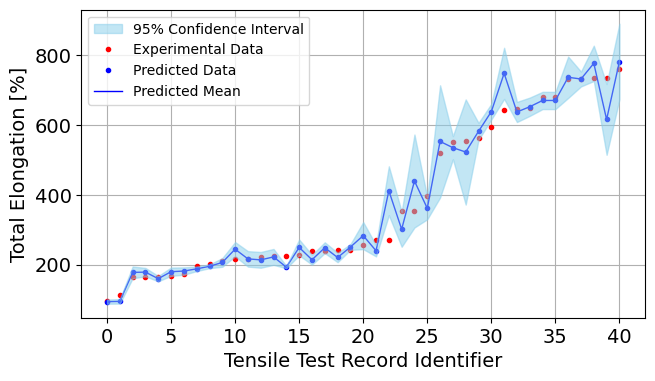

********************


100%|██████████| 3000/3000 [02:19<00:00, 21.50it/s, loss=0.517]  


Run #  1 Fold # 2
Pearson CC: 0.9838710434111069
R2 score: 0.9675989121564779
RMSE: 41.19355773925781
MAE: 18.826190948486328
Coverage: 46.34146341463415
Interval Width: 14.374755859375


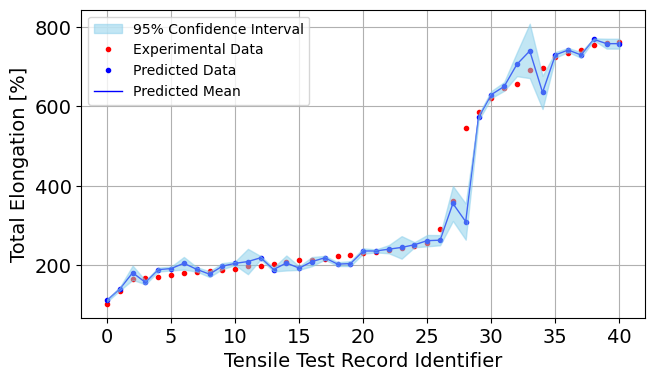

********************


100%|██████████| 3000/3000 [02:19<00:00, 21.53it/s, loss=0.426]  


Run #  1 Fold # 3
Pearson CC: 0.9917536053945898
R2 score: 0.9831477313051272
RMSE: 27.395410537719727
MAE: 19.534015655517578
Coverage: 53.65853658536585
Interval Width: 27.778564453125


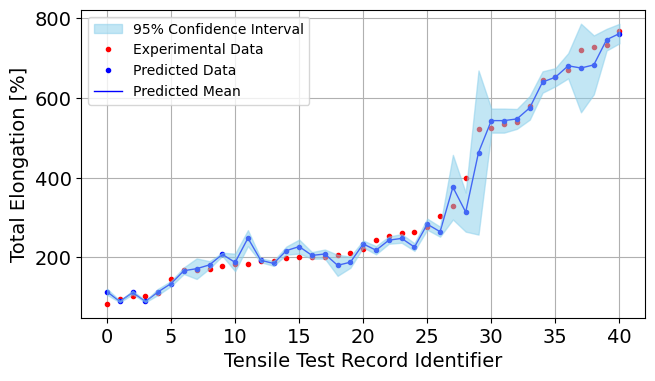

********************


100%|██████████| 3000/3000 [02:04<00:00, 24.00it/s, loss=0.967]  


Run #  1 Fold # 4
Pearson CC: 0.971000926304143
R2 score: 0.9427923377895369
RMSE: 45.78719711303711
MAE: 22.838529586791992
Coverage: 58.536585365853654
Interval Width: 23.487274169921875


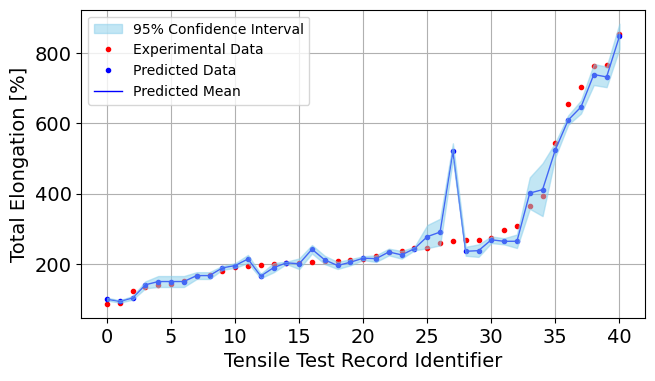

********************


100%|██████████| 3000/3000 [02:04<00:00, 24.18it/s, loss=2.962]  


Run #  1 Fold # 5
Pearson CC: 0.9940091363153489
R2 score: 0.987388493483905
RMSE: 24.45621681213379
MAE: 17.953561782836914
Coverage: 40.0
Interval Width: 16.98321533203125


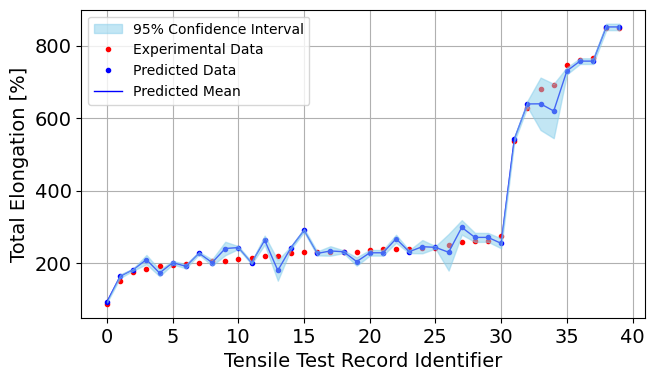

********************


In [38]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            x_train = x_train.astype(dtype=np.float32)
            x_test = x_test.astype(np.float32)
            y_train_np = y_train.to_numpy(dtype=np.float32)
            y_test_np =  y_test.to_numpy(dtype=np.float32)

            x_train = torch.from_numpy(x_train)
            y_train = torch.from_numpy(y_train_np)

            x_test = torch.from_numpy(x_test)
            y_test = torch.from_numpy(y_test_np)

            train_dataset = MyDataset(x_train, y_train)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)

            # define DNN
            class MLP(nn.Module):
                  def __init__(self, input_dim=38, output_dim=1, hidden_dim=10, n_hidden_layers=1, use_dropout=False):
                        super().__init__()

                        self.use_dropout = use_dropout
                        if use_dropout:
                              self.dropout = nn.Dropout(p=0.5)
                        self.activation = nn.ReLU()

                        # dynamically define architecture
                        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
                        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                                    range(1, len(self.layer_sizes))]
                        self.layers = nn.ModuleList(layer_list)

                  def forward(self, input):
                        hidden = self.activation(self.layers[0](input))
                        for layer in self.layers[1:-1]:
                              hidden_temp = self.activation(layer(hidden))

                              if self.use_dropout:
                                    hidden_temp = self.dropout(hidden_temp)

                              hidden = hidden_temp + hidden  # residual connection

                        output_mean = self.layers[-1](hidden).squeeze()
                        return output_mean

            def train(net, train_dataloader):
                  optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01)
                  criterion = nn.MSELoss()

                  progress_bar = trange(3000)
                  for _ in progress_bar:
                        for i, data in enumerate(train_dataloader):
                              traning_data, training_label = data
                              optimizer.zero_grad()
                              y_pred = net(torch.Tensor(traning_data))
                              loss = criterion(y_pred.squeeze(), torch.Tensor(training_label))
                              progress_bar.set_postfix(loss=f'{loss / features.shape[0]:.3f}')
                              loss.backward()
                              optimizer.step()
                  return net

            # training
            ensemble_size = 5
            ensemble = [MLP(hidden_dim=400, n_hidden_layers=2) for _ in range(ensemble_size)]

            for net in ensemble:
                  train(net, train_dataloader)

            print("Run # ", j+1, "Fold #", i+1)

            # inference
            y_preds = [np.array(net(torch.Tensor(x_test)).clone().detach().numpy()) for net in ensemble]
            # mean and standard deviation
            y_pred = np.mean(np.array(y_preds), axis=0)
            y_std = np.std(np.array(y_preds), axis=0)


            ## Metrics for evaluating the predictive accuracy of the model
            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            ## Metrics for evaluating the uncertainty quantification of the model
            # Coverage
            def coverage(y, yL, yH):
                  return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

            df_test_low = y_pred - 2*y_std
            df_test_mean = y_pred
            df_test_high = y_pred + 2*y_std


            test_coverage[j, i] = coverage(y_test_np, df_test_low, df_test_high)
            print(f'Coverage: {test_coverage[j, i]}')


            # Prediction interval width
            # Quantifies the average width of the prediction intervals. Smaller widths suggest more precise uncertainty estimates.
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            # Composite metric that combines the coverage and the invers of interval width
            ax[0].fill_between(iteration_list, y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.5, color='skyblue', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ro', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'bo', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="blue", label="Predicted Mean")
            ax[0].legend(fontsize=10, frameon=True, loc="upper left")
            ax[0].set_xlabel("Tensile Test Record Identifier", fontsize=14)
            ax[0].set_ylabel("Total Elongation [%]", fontsize=14)
            ax[0].tick_params(axis='both', which='major', labelsize=14)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.8')


            fig.delaxes(ax[1])
            plt.show()
            print(20*'*')

In [39]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.982666,0.964005,41.326332,26.618116,58.536585
1,0.983871,0.967599,41.193558,18.826191,46.341463
2,0.991754,0.983148,27.395411,19.534016,53.658537
3,0.971001,0.942792,45.787197,22.838530,58.536585
4,0.994009,0.987388,24.456217,17.953562,40.000000


In [40]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.98466,0.00811,0.968986,0.015824,36.031743,8.466699,21.154083,3.193119,51.414634,7.245832


In [41]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,58.536585,45.183014,0.0
1,46.341463,14.374756,0.0
2,53.658537,27.778564,0.0
3,58.536585,23.487274,0.0
4,40.000000,16.983215,0.0


In [42]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)

median_interval_width_mean = np.mean(median_interval_width)

test_coverage_std = np.std(test_coverage)

median_interval_width_std = np.std(median_interval_width)


# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std
                },index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std
0,51.414634,7.245832,25.561365,10.88992
